## 1. Import Libraries

In [243]:
from os.path import join
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import loadmat
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
pd.options.mode.chained_assignment = None

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import math

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix, mean_squared_error, make_scorer, mean_absolute_error, mean_absolute_percentage_error

## 2. Merge all trip_metrics

In [244]:
#from google.colab import drive
#drive.mount('/content/drive')

In [245]:
trip_metrics_1 = pd.read_csv("../Yeni dosyalar/trip_metrics_1-6.csv")
trip_metrics_2 = pd.read_csv("../Yeni dosyalar/trip_metrics_7-12.csv")
trip_metrics_3 = pd.read_csv("../Yeni dosyalar/trip_metrics_13-18.csv")
trip_metrics_4 = pd.read_csv("../Yeni dosyalar/trip_metrics_19-24.csv")
trip_metrics_5 = pd.read_csv("../Yeni dosyalar/trip_metrics_25-30.csv")

df_list = [trip_metrics_1,trip_metrics_2,trip_metrics_3,trip_metrics_4,trip_metrics_5]
trips_merged = pd.concat(df_list)
trips_merged.to_csv('trips_merged.csv',index=False)
trips_merged


,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean,State_Name
0,vehicle_106_2013-01-02_trip_1,56.512577,2013-01-02 17:03:03,2013-01-03 06:59:37,30054,3.059713,25.543506,53.10822,0.0,0.682558,...,-36.0,186.0,0.0,27.401732,-0.701630,2538.156197,32.138279,0.094478,2.167538,New York
1,vehicle_106_2013-01-03_trip_1,67.325737,2013-01-03 07:00:39,2013-01-04 06:59:01,61184,5.406763,91.890939,54.71756,0.0,0.652998,...,-18.0,154.0,0.0,19.594187,0.645511,2509.308584,-4.814485,-0.027146,1.835317,New York
2,vehicle_106_2013-01-04_trip_1,73.932923,2013-01-04 07:00:03,2013-01-05 06:45:37,65658,0.615856,11.232193,54.71756,0.0,0.654898,...,-25.0,100.0,0.0,14.865846,2.540228,2507.926606,99.693687,0.191294,1.923882,New York
3,vehicle_106_2013-01-05_trip_1,-113.205677,2013-01-05 07:12:24,2013-01-06 01:34:20,52863,18.642805,273.754051,54.71756,0.0,0.620325,...,-134.0,405.0,0.0,56.241256,4.485057,2517.485382,-6.452550,-0.015366,2.153184,New York
4,vehicle_106_2013-01-07_trip_1,0.082100,2013-01-08 03:24:30,2013-01-08 06:59:59,12929,0.000875,0.003143,1.60934,0.0,0.447039,...,-4.0,55.0,0.0,20.422091,8.330394,2499.255762,65241.277748,91728.000000,2.113689,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2228,vehicle_441_2015-01-07_trip_1,48.259822,2015-01-07 09:16:14,2015-01-08 01:38:05,6153,30.360591,51.891309,54.71756,0.0,0.615739,...,-37.0,118.0,0.0,25.376619,-6.627231,NaN,-0.303934,-0.000381,1.809065,New Jersey
2229,vehicle_441_2015-01-08_trip_1,50.762781,2015-01-08 07:40:24,2015-01-09 01:09:45,6965,28.826084,55.770466,54.71756,0.0,0.601900,...,-43.0,94.0,0.0,25.596772,-10.669776,NaN,-0.565587,-0.000774,1.791352,New Jersey
2230,vehicle_441_2015-01-09_trip_1,44.076312,2015-01-09 07:02:21,2015-01-10 01:01:30,5877,27.029152,44.125091,54.71756,0.0,0.625577,...,-23.0,103.0,0.0,28.478131,-3.154897,NaN,-8.202602,-0.008253,1.778323,New Jersey
2231,vehicle_441_2015-01-10_trip_1,41.304916,2015-01-10 09:12:36,2015-01-11 00:05:32,6125,23.705111,40.331612,54.71756,0.0,0.615101,...,-57.0,123.0,0.0,29.333582,-8.270477,NaN,13.646722,0.014555,1.676657,New Jersey


In [246]:
# if you have all data just use this method
trips_merged = pd.read_csv("../Yeni dosyalar/trips_merged.csv")
trips_merged

,ID,Energy_Consumption_kWh,Start_Time,End_Time,Duration_s,Average_Speed_kmh,Total_Distance_km,Max_Speed,Min_Speed,Positive_Acceleration_Mean,...,Min_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Characteristic_Acceleration,Kinetic_Intensity,Traffic_Category_Mean,State_Name
0,vehicle_106_2013-01-02_trip_1,56.512577,2013-01-02 17:03:03,2013-01-03 06:59:37,30054,3.059713,25.543506,53.10822,0.0,0.682558,...,-36.0,186.0,0.0,27.401732,-0.701630,2538.156197,32.138279,0.094478,2.167538,New York
1,vehicle_106_2013-01-03_trip_1,67.325737,2013-01-03 07:00:39,2013-01-04 06:59:01,61184,5.406763,91.890939,54.71756,0.0,0.652998,...,-18.0,154.0,0.0,19.594187,0.645511,2509.308584,-4.814485,-0.027146,1.835317,New York
2,vehicle_106_2013-01-04_trip_1,73.932923,2013-01-04 07:00:03,2013-01-05 06:45:37,65658,0.615856,11.232193,54.71756,0.0,0.654898,...,-25.0,100.0,0.0,14.865846,2.540228,2507.926606,99.693687,0.191294,1.923882,New York
3,vehicle_106_2013-01-05_trip_1,-113.205677,2013-01-05 07:12:24,2013-01-06 01:34:20,52863,18.642805,273.754051,54.71756,0.0,0.620325,...,-134.0,405.0,0.0,56.241256,4.485057,2517.485382,-6.452550,-0.015366,2.153184,New York
4,vehicle_106_2013-01-07_trip_1,0.082100,2013-01-08 03:24:30,2013-01-08 06:59:59,12929,0.000875,0.003143,1.60934,0.0,0.447039,...,-4.0,55.0,0.0,20.422091,8.330394,2499.255762,65241.277748,91728.000000,2.113689,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10314,vehicle_441_2015-01-07_trip_1,48.259822,2015-01-07 09:16:14,2015-01-08 01:38:05,6153,30.360591,51.891309,54.71756,0.0,0.615739,...,-37.0,118.0,0.0,25.376619,-6.627231,NaN,-0.303934,-0.000381,1.809065,New Jersey
10315,vehicle_441_2015-01-08_trip_1,50.762781,2015-01-08 07:40:24,2015-01-09 01:09:45,6965,28.826084,55.770466,54.71756,0.0,0.601900,...,-43.0,94.0,0.0,25.596772,-10.669776,NaN,-0.565587,-0.000774,1.791352,New Jersey
10316,vehicle_441_2015-01-09_trip_1,44.076312,2015-01-09 07:02:21,2015-01-10 01:01:30,5877,27.029152,44.125091,54.71756,0.0,0.625577,...,-23.0,103.0,0.0,28.478131,-3.154897,NaN,-8.202602,-0.008253,1.778323,New Jersey
10317,vehicle_441_2015-01-10_trip_1,41.304916,2015-01-10 09:12:36,2015-01-11 00:05:32,6125,23.705111,40.331612,54.71756,0.0,0.615101,...,-57.0,123.0,0.0,29.333582,-8.270477,NaN,13.646722,0.014555,1.676657,New Jersey


## 3. Splitting the data to train test

In [247]:
# trips_merged['Energy_Consumption_kWh'] = trips_merged['Energy_Consumption_kWh'] / trips_merged['Total_Distance_km']
trips_merged = trips_merged.rename(columns={"Energy_Consumption_kWh": "Energy_Consumption_kWh/km"})

In [248]:
state_dict = ['Nebraska','内蒙古自治区','Алматы облысы','Pays de la Loire','Comunitat Valenciana','Michigan', None]
trips_merged['State_Name']  = trips_merged['State_Name'].replace(state_dict, 'Unknown')
trips_merged['State_Name'].unique()

array(['New York', 'Unknown', 'Indiana', 'Missouri', 'California',
       'Washington', 'Arizona', 'Maryland', 'District of Columbia',
       'New Jersey', 'Illinois', 'Wisconsin', 'Virginia'], dtype=object)

In [249]:
trips_merged = trips_merged.dropna()

In [250]:
cols_to_keep = ['Duration_s', 'Average_Speed_kmh', 'Max_Speed',
       'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude',
       'Min_Altitude', 'GPS_Altitude_Mean', 'Average_Ambient_Temperature',
       'Average_air', 'Kinetic_Intensity', 'Traffic_Category_Mean',
       'State_Name','Total_Distance_km']

In [251]:
X = trips_merged[cols_to_keep]
y = trips_merged['Energy_Consumption_kWh/km']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=55, stratify=X['State_Name'])

In [252]:
X_train.columns

Index(['Duration_s', 'Average_Speed_kmh', 'Max_Speed',
       'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude', 'Min_Altitude',
       'GPS_Altitude_Mean', 'Average_Ambient_Temperature', 'Average_air',
       'Kinetic_Intensity', 'Traffic_Category_Mean', 'State_Name',
       'Total_Distance_km'],
      dtype='object')

In [253]:
X_test.columns

Index(['Duration_s', 'Average_Speed_kmh', 'Max_Speed',
       'Positive_Acceleration_Mean', 'Positive_Acceleration_Sum',
       'Positive_Altitude-diff_Mean', 'Positive_Altitude-diff_Sum',
       'Max_Altitude-diff', 'Max_Altitude', 'Min_Altitude',
       'GPS_Altitude_Mean', 'Average_Ambient_Temperature', 'Average_air',
       'Kinetic_Intensity', 'Traffic_Category_Mean', 'State_Name',
       'Total_Distance_km'],
      dtype='object')

In [254]:
y_test

10087    52.705189
6603      3.037732
8304      4.965696
2644     39.159260
9105     26.524422
           ...    
418      22.702244
2213     24.835888
1655     36.401638
123      27.106556
9991     19.445744
Name: Energy_Consumption_kWh/km, Length: 1960, dtype: float64

<Axes: >

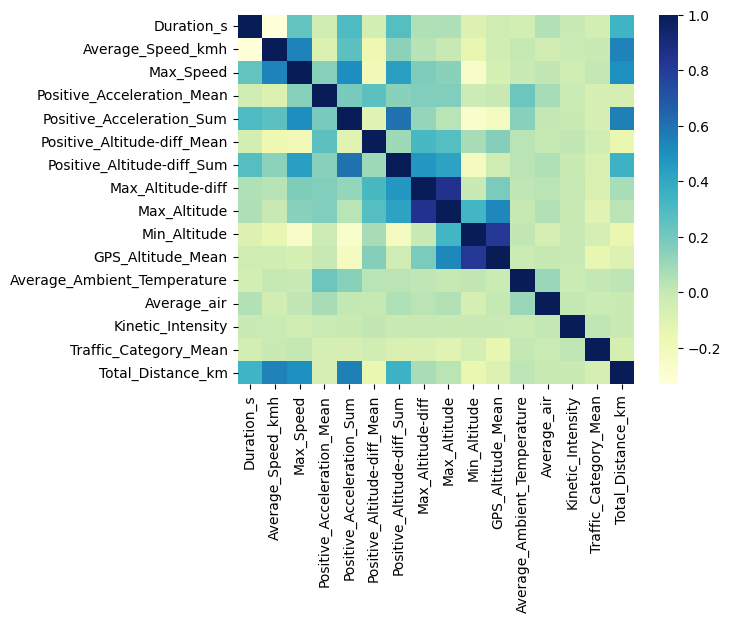

In [255]:
sns.heatmap(X_train.drop(columns=["State_Name"]).corr(), cmap="YlGnBu")

<Axes: >

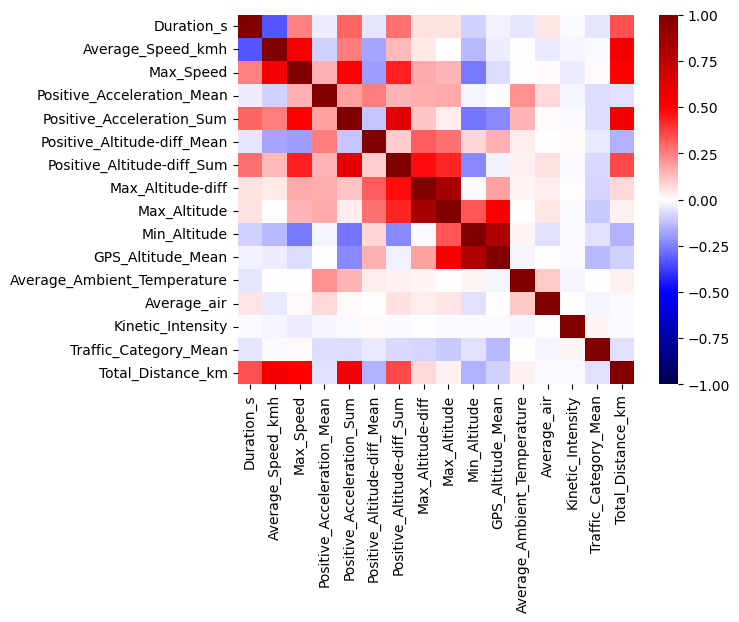

In [256]:
vmin = -1
vmax = 1
cmap = sns.color_palette(["red", "white", "green"])
sns.heatmap(X_train.drop(columns=["State_Name"]).corr(), cmap = "seismic" ,center=0,  fmt=".1f", vmin=vmin, vmax=vmax,)

In [257]:
X_train.drop(columns=['State_Name']).corr()


,Duration_s,Average_Speed_kmh,Max_Speed,Positive_Acceleration_Mean,Positive_Acceleration_Sum,Positive_Altitude-diff_Mean,Positive_Altitude-diff_Sum,Max_Altitude-diff,Max_Altitude,Min_Altitude,GPS_Altitude_Mean,Average_Ambient_Temperature,Average_air,Kinetic_Intensity,Traffic_Category_Mean,Total_Distance_km
Duration_s,1.000000,-0.332046,0.245401,-0.031322,0.302033,-0.048600,0.280462,0.055880,0.060401,-0.088943,-0.030531,-0.048705,0.052263,-0.009045,-0.050616,0.342235
Average_Speed_kmh,-0.332046,1.000000,0.545799,-0.086648,0.257384,-0.175766,0.138509,0.039976,-0.001220,-0.139157,-0.038401,0.004913,-0.044721,-0.016873,-0.013301,0.550284
Max_Speed,0.245401,0.545799,1.000000,0.149432,0.506529,-0.189390,0.433210,0.167503,0.143185,-0.261161,-0.065350,-0.004248,0.015266,-0.036871,0.010691,0.501449
Positive_Acceleration_Mean,-0.031322,-0.086648,0.149432,1.000000,0.184049,0.256169,0.144461,0.162734,0.166359,-0.021427,-0.000239,0.214524,0.074713,-0.019408,-0.065154,-0.056969
Positive_Acceleration_Sum,0.302033,0.257384,0.506529,0.184049,1.000000,-0.111669,0.603669,0.116901,0.037036,-0.273070,-0.232936,0.147360,0.010243,-0.013967,-0.069320,0.554970
Positive_Altitude-diff_Mean,-0.048600,-0.175766,-0.189390,0.256169,-0.111669,1.000000,0.095773,0.313896,0.278839,0.078601,0.152479,0.035827,0.004185,0.013468,-0.040401,-0.149386
Positive_Altitude-diff_Sum,0.280462,0.138509,0.433210,0.144461,0.603669,0.095773,1.000000,0.474464,0.425771,-0.229693,-0.029285,0.030360,0.055660,-0.012828,-0.077887,0.354711
Max_Altitude-diff,0.055880,0.039976,0.167503,0.162734,0.116901,0.313896,0.474464,1.000000,0.849204,-0.009019,0.182431,0.018126,0.031405,-0.001231,-0.078992,0.072690
Max_Altitude,0.060401,-0.001220,0.143185,0.166359,0.037036,0.278839,0.425771,0.849204,1.000000,0.331511,0.529459,0.003574,0.051394,-0.010241,-0.108989,0.029198
Min_Altitude,-0.088943,-0.139157,-0.261161,-0.021427,-0.273070,0.078601,-0.229693,-0.009019,0.331511,1.000000,0.818930,0.015794,-0.060077,-0.009385,-0.055700,-0.148543


## 4. Feature Enginnering

In [258]:
X_train = pd.get_dummies(X_train, columns=['State_Name'], prefix="",prefix_sep="") 
X_test = pd.get_dummies(X_test, columns=['State_Name'], prefix="",prefix_sep="") 

## 5. Applying Machine Learning Models

In [259]:
def custom_metric(predictions, actual_values):
    error = abs(predictions - actual_values) / actual_values
    if error <= 0.1:
        return 1
    else:
        return 0

## Random Forest

In [260]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

mse = mean_absolute_error(y_test, predictions)
print(mse)


6.856887211344954


In [261]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['predictions'], row['Energy_Consumption_kWh/km']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print(accuracy)

0.5045918367346939


C:\Users\Yunus\AppData\Local\Temp\ipykernel_10124\2036942856.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  error = abs(predictions - actual_values) / actual_values


## XGBoost

In [262]:
mse = make_scorer(mean_squared_error)
params = {
    'max_depth': [9],
 
    'subsample':[0.9],
    'colsample_bytree':[0.9],
    'gamma':[0.3]
}

# create an XGB Boost instance
xgb_reg = XGBRegressor(

  
)

# searching the model
XGB_Model= GridSearchCV(estimator = xgb_reg, param_grid= params, n_jobs = 4, cv = 5, verbose = True, scoring=mse)


In [263]:
XGB_Model.fit(X_train, y_train)
predictions = XGB_Model.predict(X_test)

mse = mean_absolute_error(y_test, predictions)
print(mse)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
7.269857210169499


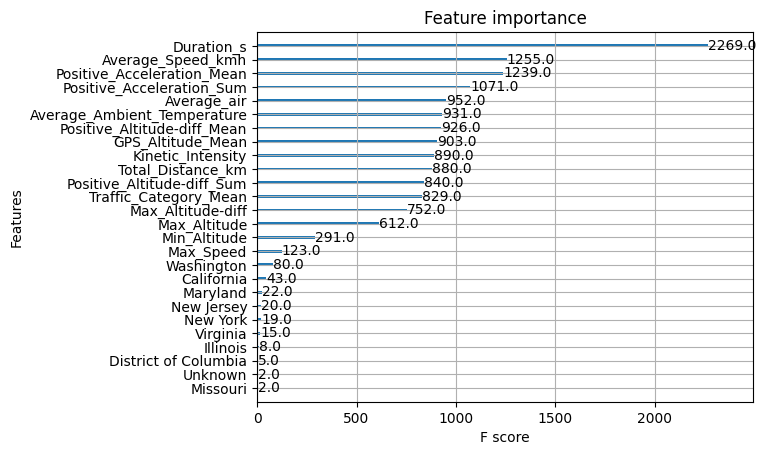

In [264]:
from xgboost import plot_importance
plot_importance(XGB_Model.best_estimator_)
plt.show()

In [265]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['predictions'], row['Energy_Consumption_kWh/km']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print(accuracy)

0.4714285714285714


C:\Users\Yunus\AppData\Local\Temp\ipykernel_10124\2036942856.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  error = abs(predictions - actual_values) / actual_values


## Extra Trees

In [266]:
clf = ExtraTreesRegressor(n_estimators = 500)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

mse = mean_absolute_error(y_test, predictions)
print(mse)


6.702682593445293


In [267]:
df_temp = pd.DataFrame(y_test)
df_temp['predictions'] = predictions.tolist()
df_temp['class'] = df_temp.apply(lambda row: custom_metric(row['predictions'], row['Energy_Consumption_kWh/km']), axis=1)
accuracy = df_temp['class'].value_counts()[1] / df_temp.shape[0]
print(accuracy)

0.5295918367346939


C:\Users\Yunus\AppData\Local\Temp\ipykernel_10124\2036942856.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  error = abs(predictions - actual_values) / actual_values
